In [ ]:
# Install Java (required for Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Apache Spark 3.5.0 with Hadoop 3
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Install required Python packages
!pip install -q findspark
!pip install pyspark==3.5.5

In [ ]:
import os

# Automatically detect Java version path (Java 8 or 11, whichever is installed)
java_8_path = "/usr/lib/jvm/java-8-openjdk-amd64"
java_11_path = "/usr/lib/jvm/java-11-openjdk-amd64"

# Use whichever Java version is available
if os.path.exists(java_8_path):
    os.environ["JAVA_HOME"] = java_8_path
elif os.path.exists(java_11_path):
    os.environ["JAVA_HOME"] = java_11_path
else:
    raise EnvironmentError("No compatible Java version found.")

# Update to Spark 3.5.0 path
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
# Initialize Spark with findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, to_date, to_timestamp
from pyspark.sql.types import *

# Optional: useful utilities
from datetime import datetime, date, timedelta
import random

In [ ]:
# Initialize a SparkSession (entry point to Spark functionality)
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("My First Spark App") \
    .master("local[*]") \
    .getOrCreate()

# Optional: Check the Spark version
print("Spark version:", spark.version)

Spark version: 3.5.0


In [ ]:
# View all Spark configuration settings
for item in spark.sparkContext.getConf().getAll():
    print(f"{item[0]} = {item[1]}")

spark.executor.id = driver
spark.app.submitTime = 1748281068038
spark.app.id = local-1748281072102
spark.driver.port = 46851
spark.driver.extraJavaOptions = -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.startTime = 1748281068447
sp

Data Loading and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Merging PM2.5 data for year 2020 to 2024

In [ ]:
import os
import pandas as pd
import glob

# Define the full path to your folder
pm25_path = "/content/drive/My Drive/Big Data Project/Data/Raw/PM25"

# Glob all CSV files
pm25_files = glob.glob(os.path.join(pm25_path, "*.csv"))

# Load and concatenate all PM2.5 CSVs
pm25_dfs = [pd.read_csv(file) for file in pm25_files]
pm25_all = pd.concat(pm25_dfs, ignore_index=True)

# Optional cleanup
pm25_all["Date Local"] = pd.to_datetime(pm25_all["Date Local"])
pm25_all = pm25_all.rename(columns={"Arithmetic Mean": "pm25"})

# Keep only relevant columns
pm25_all = pm25_all[[
    "State Name", "County Name", "Site Num", "Date Local", "pm25", "Latitude", "Longitude"
]]

# Save combined dataset back to Drive
output_path = "/content/drive/My Drive/Big Data Project/Data/Processed/pm25_master_2020_2024.csv"
pm25_all.to_csv(output_path, index=False)

print(f"Saved merged file to: {output_path}")


<ipython-input-42-b963d8edc00c>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  pm25_dfs = [pd.read_csv(file) for file in pm25_files]


Saved merged file to: /content/drive/My Drive/Big Data Project/Data/Processed/pm25_master_2020_2024.csv


In [ ]:
#Checking data
pm25_all.head()

,State Name,County Name,Site Num,Date Local,pm25,Latitude,Longitude
0,Alabama,Baldwin,10,2022-01-02,5.3,30.497478,-87.880258
1,Alabama,Baldwin,10,2022-01-05,8.6,30.497478,-87.880258
2,Alabama,Baldwin,10,2022-01-08,8.5,30.497478,-87.880258
3,Alabama,Baldwin,10,2022-01-11,3.7,30.497478,-87.880258
4,Alabama,Baldwin,10,2022-01-14,11.6,30.497478,-87.880258


In [ ]:
#Show shape of data (row & column count)
print("Shape:", pm25_all.shape, "\n")

# Show general structure: dtypes, non-nulls, memory usage
pm25_all.info()

# Show statistical summary (mean, std, min, max, etc.)
print("\n Summary statistics:")
print(pm25_all.describe())

# Count of missing values in each column
print("\n Null value counts:")
print(pm25_all.isnull().sum())

#Check for duplicate rows
print("\n Duplicate rows:", pm25_all.duplicated().sum())

Shape: (3637478, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637478 entries, 0 to 3637477
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   State Name   object        
 1   County Name  object        
 2   Site Num     int64         
 3   Date Local   datetime64[ns]
 4   pm25         float64       
 5   Latitude     float64       
 6   Longitude    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 194.3+ MB

 Summary statistics:
           Site Num                     Date Local          pm25  \
count  3.637478e+06                        3637478  3.637478e+06   
mean   6.788443e+02  2022-05-05 15:01:46.156847872  8.010482e+00   
min    1.000000e+00            2020-01-01 00:00:00 -2.212917e+01   
25%    7.000000e+00            2021-04-09 00:00:00  4.400000e+00   
50%    2.500000e+01            2022-05-20 00:00:00  6.600000e+00   
75%    1.001000e+03            2023-05-27 00:00:00  9.70

In [ ]:
# Check again how many rows we have before cleaning
print("Before:", pm25_all.shape)

# Remove exact duplicates
pm25_all = pm25_all.drop_duplicates()

# Check the result
print("After :", pm25_all.shape)

Before: (3637478, 7)
After : (3533765, 7)


## Merging O3 dataset from year 2020 to 2024

In [ ]:
import os
import pandas as pd
import glob

# Define the full path to your folder
o3_path = "/content/drive/My Drive/Big Data Project/Data/Raw/O3"

# Glob all CSV files
o3_files = glob.glob(os.path.join(o3_path, "*.csv"))

# Load and concatenate all O3 CSVs
o3_dfs = [pd.read_csv(file) for file in o3_files]
o3_all = pd.concat(o3_dfs, ignore_index=True)

# Optional cleanup
o3_all["Date Local"] = pd.to_datetime(o3_all["Date Local"])
o3_all = o3_all.rename(columns={"Arithmetic Mean": "O3"})

# Keep only relevant columns
o3_all = o3_all[[
    "State Name", "County Name", "Site Num", "Date Local", "O3", "Latitude", "Longitude"
]]

# Save combined dataset back to Drive
output_path = "/content/drive/My Drive/Big Data Project/Data/Processed/o3_master_2020_2024.csv"
o3_all.to_csv(output_path, index=False)

print(f"Saved merged file to: {output_path}")

<ipython-input-46-bab7c073078f>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  o3_dfs = [pd.read_csv(file) for file in o3_files]
<ipython-input-46-bab7c073078f>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  o3_dfs = [pd.read_csv(file) for file in o3_files]
<ipython-input-46-bab7c073078f>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  o3_dfs = [pd.read_csv(file) for file in o3_files]
<ipython-input-46-bab7c073078f>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  o3_dfs = [pd.read_csv(file) for file in o3_files]
<ipython-input-46-bab7c073078f>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  o3_dfs = [pd.read_csv(file) for file in o3_files]


Saved merged file to: /content/drive/My Drive/Big Data Project/Data/Processed/o3_master_2020_2024.csv


In [ ]:
#Show shape of data (row & column count)
print("Shape:", o3_all.shape, "\n")

# Show general structure: dtypes, non-nulls, memory usage
o3_all.info()

# Show statistical summary (mean, std, min, max, etc.)
print("\n Summary statistics:")
print(o3_all.describe())

# Count of missing values in each column
print("\n Null value counts:")
print(o3_all.isnull().sum())

#Check for duplicate rows
print("\n Duplicate rows:", o3_all.duplicated().sum())

Shape: (1804612, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804612 entries, 0 to 1804611
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   State Name   object        
 1   County Name  object        
 2   Site Num     int64         
 3   Date Local   datetime64[ns]
 4   O3           float64       
 5   Latitude     float64       
 6   Longitude    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 96.4+ MB

 Summary statistics:
           Site Num                     Date Local            O3  \
count  1.804612e+06                        1804612  1.804612e+06   
mean   1.343311e+03  2022-04-20 22:52:35.419115008  3.260714e-02   
min    1.000000e+00            2020-01-01 00:00:00 -3.300000e-03   
25%    6.000000e+00            2021-03-07 00:00:00  2.488200e-02   
50%    2.400000e+01            2022-04-26 00:00:00  3.252900e-02   
75%    1.016000e+03            2023-06-18 00:00:00  4.000

In [ ]:
# Check again how many rows we have before cleaning
print("Before:", o3_all.shape)

# Remove exact duplicates
o3_all = o3_all.drop_duplicates()

# Check the result
print("After :", o3_all.shape)

Before: (1804612, 7)
After : (1801674, 7)


### Merging NO2 dataset from year 2020 to 2024

In [ ]:
import os
import pandas as pd
import glob

# Define the full path to your folder
no2_path = "/content/drive/My Drive/Big Data Project/Data/Raw/NO2"

# Glob all CSV files
no2_files = glob.glob(os.path.join(no2_path, "*.csv"))

# Load and concatenate all NO2 CSVs
no2_dfs = [pd.read_csv(file) for file in no2_files]
no2_all = pd.concat(no2_dfs, ignore_index=True)

# Optional cleanup
no2_all["Date Local"] = pd.to_datetime(no2_all["Date Local"])
no2_all = no2_all.rename(columns={"Arithmetic Mean": "NO2"})

# Keep only relevant columns
no2_all = no2_all[[
    "State Name", "County Name", "Site Num", "Date Local", "NO2", "Latitude", "Longitude"
]]

# Save combined dataset back to Drive
output_path = "/content/drive/My Drive/Big Data Project/Data/Processed/no2_master_2020_2024.csv"
no2_all.to_csv(output_path, index=False)

print(f"Saved merged file to: {output_path}")

<ipython-input-49-7e46044b5209>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  no2_dfs = [pd.read_csv(file) for file in no2_files]
<ipython-input-49-7e46044b5209>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  no2_dfs = [pd.read_csv(file) for file in no2_files]
<ipython-input-49-7e46044b5209>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  no2_dfs = [pd.read_csv(file) for file in no2_files]
<ipython-input-49-7e46044b5209>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  no2_dfs = [pd.read_csv(file) for file in no2_files]


Saved merged file to: /content/drive/My Drive/Big Data Project/Data/Processed/no2_master_2020_2024.csv


In [ ]:
#Show shape of data (row & column count)
print("Shape:", no2_all.shape, "\n")

# Show general structure: dtypes, non-nulls, memory usage
no2_all.info()

# Show statistical summary (mean, std, min, max, etc.)
print("\n Summary statistics:")
print(no2_all.describe())

# Count of missing values in each column
print("\n Null value counts:")
print(no2_all.isnull().sum())

#Check for duplicate rows
print("\n Duplicate rows:", no2_all.duplicated().sum())

Shape: (719289, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719289 entries, 0 to 719288
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   State Name   719289 non-null  object        
 1   County Name  719289 non-null  object        
 2   Site Num     719289 non-null  int64         
 3   Date Local   719289 non-null  datetime64[ns]
 4   NO2          719289 non-null  float64       
 5   Latitude     719289 non-null  float64       
 6   Longitude    719289 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 38.4+ MB

 Summary statistics:
            Site Num                     Date Local            NO2  \
count  719289.000000                         719289  719289.000000   
mean      962.083526  2022-04-10 00:16:42.269741312       7.636649   
min         1.000000            2020-01-01 00:00:00      -4.495833   
25%        10.000000            202

In [ ]:
# Check again how many rows we have before cleaning
print("Before:", no2_all.shape)

# Remove exact duplicates
no2_all = no2_all.drop_duplicates()

# Check the result
print("After :", no2_all.shape)

Before: (719289, 7)
After : (719272, 7)


## Merging CO dataset from year 2020 to 2024

In [ ]:
import os
import pandas as pd
import glob

# Define the full path to your folder
co_path = "/content/drive/My Drive/Big Data Project/Data/Raw/CO"

# Glob all CSV files
co_files = glob.glob(os.path.join(co_path, "*.csv"))

# Load and concatenate all CO CSVs
co_dfs = [pd.read_csv(file) for file in co_files]
co_all = pd.concat(co_dfs, ignore_index=True)

# Optional cleanup
co_all["Date Local"] = pd.to_datetime(co_all["Date Local"])
co_all = co_all.rename(columns={"Arithmetic Mean": "CO"})

# Keep only relevant columns
co_all = co_all[[
    "State Name", "County Name", "Site Num", "Date Local", "CO", "Latitude", "Longitude"
]]

# Save combined dataset back to Drive
output_path = "/content/drive/My Drive/Big Data Project/Data/Processed/co_master_2020_2024.csv"
co_all.to_csv(output_path, index=False)

print(f"Saved merged file to: {output_path}")

<ipython-input-52-b26836bb4ed7>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  co_dfs = [pd.read_csv(file) for file in co_files]
<ipython-input-52-b26836bb4ed7>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  co_dfs = [pd.read_csv(file) for file in co_files]
<ipython-input-52-b26836bb4ed7>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  co_dfs = [pd.read_csv(file) for file in co_files]
<ipython-input-52-b26836bb4ed7>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  co_dfs = [pd.read_csv(file) for file in co_files]
<ipython-input-52-b26836bb4ed7>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  co_dfs = [pd.read_csv(file) for file in co_files]


Saved merged file to: /content/drive/My Drive/Big Data Project/Data/Processed/co_master_2020_2024.csv


In [ ]:
#Show shape of data (row & column count)
print("Shape:", co_all.shape, "\n")

# Show general structure: dtypes, non-nulls, memory usage
co_all.info()

# Show statistical summary (mean, std, min, max, etc.)
print("\n Summary statistics:")
print(co_all.describe())

# Count of missing values in each column
print("\n Null value counts:")
print(co_all.isnull().sum())

#Check for duplicate rows
print("\n Duplicate rows:", co_all.duplicated().sum())

Shape: (775352, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775352 entries, 0 to 775351
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   State Name   775352 non-null  object        
 1   County Name  775352 non-null  object        
 2   Site Num     775352 non-null  int64         
 3   Date Local   775352 non-null  datetime64[ns]
 4   CO           775352 non-null  float64       
 5   Latitude     775352 non-null  float64       
 6   Longitude    775352 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 41.4+ MB

 Summary statistics:
            Site Num                     Date Local             CO  \
count  775352.000000                         775352  775352.000000   
mean      967.564278  2022-03-23 02:30:51.277871872       0.275435   
min         1.000000            2020-01-01 00:00:00      -0.400000   
25%        15.000000            202

In [ ]:
# Check again how many rows we have before cleaning
print("Before:", co_all.shape)

# Remove exact duplicates
co_all = co_all.drop_duplicates()

# Check the result
print("After :", co_all.shape)

Before: (775352, 7)
After : (752821, 7)


### Merging SO2 dataset from year 2020 to 2024

In [ ]:
import os
import pandas as pd
import glob

# Define the full path to your folder
so2_path = "/content/drive/My Drive/Big Data Project/Data/Raw/SO2"

# Glob all CSV files
so2_files = glob.glob(os.path.join(so2_path, "*.csv"))

# Load and concatenate all NO2 CSVs
so2_dfs = [pd.read_csv(file) for file in so2_files]
so2_all = pd.concat(so2_dfs, ignore_index=True)

# Optional cleanup
so2_all["Date Local"] = pd.to_datetime(so2_all["Date Local"])
so2_all = so2_all.rename(columns={"Arithmetic Mean": "SO2"})

# Keep only relevant columns
so2_all = so2_all[[
    "State Name", "County Name", "Site Num", "Date Local", "SO2", "Latitude", "Longitude"
]]

# Save combined dataset back to Drive
output_path = "/content/drive/My Drive/Big Data Project/Data/Processed/so2_master_2020_2024.csv"
so2_all.to_csv(output_path, index=False)

print(f"Saved merged file to: {output_path}")

<ipython-input-55-28160c89c398>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  so2_dfs = [pd.read_csv(file) for file in so2_files]
<ipython-input-55-28160c89c398>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  so2_dfs = [pd.read_csv(file) for file in so2_files]
<ipython-input-55-28160c89c398>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  so2_dfs = [pd.read_csv(file) for file in so2_files]
<ipython-input-55-28160c89c398>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  so2_dfs = [pd.read_csv(file) for file in so2_files]
<ipython-input-55-28160c89c398>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  so2_dfs = [pd.read_csv(file) for file in so2_files]


Saved merged file to: /content/drive/My Drive/Big Data Project/Data/Processed/so2_master_2020_2024.csv


In [ ]:
#Show shape of data (row & column count)
print("Shape:", so2_all.shape, "\n")

# Show general structure: dtypes, non-nulls, memory usage
so2_all.info()

# Show statistical summary (mean, std, min, max, etc.)
print("\n Summary statistics:")
print(so2_all.describe())

# Count of missing values in each column
print("\n Null value counts:")
print(so2_all.isnull().sum())

#Check for duplicate rows
print("\n Duplicate rows:", so2_all.duplicated().sum())

Shape: (1373161, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373161 entries, 0 to 1373160
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   State Name   1373161 non-null  object        
 1   County Name  1373161 non-null  object        
 2   Site Num     1373161 non-null  int64         
 3   Date Local   1373161 non-null  datetime64[ns]
 4   SO2          1373161 non-null  float64       
 5   Latitude     1373161 non-null  float64       
 6   Longitude    1373161 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 73.3+ MB

 Summary statistics:
           Site Num                     Date Local           SO2  \
count  1.373161e+06                        1373161  1.373161e+06   
mean   9.260615e+02  2022-03-20 04:46:34.855956224  9.044047e-01   
min    1.000000e+00            2020-01-01 00:00:00 -3.916667e+00   
25%    7.000000e+00            

In [ ]:
# Check again how many rows we have before cleaning
print("Before:", so2_all.shape)

# Remove exact duplicates
so2_all = so2_all.drop_duplicates()

# Check the result
print("After :", so2_all.shape)

Before: (1373161, 7)
After : (1287911, 7)


Based on all the 5 merged datasets, it can be observed that there are no null values.

### Merge all the files to create a master file of pollutants

In [ ]:
import os
import pandas as pd
import glob
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define base path
base_path = "/content/drive/My Drive/Big Data Project/Data"

# Define pollutant paths
pollutant_paths = {
    "PM25": os.path.join(base_path, "Raw/PM25"),
    "O3": os.path.join(base_path, "Raw/O3"),
    "NO2": os.path.join(base_path, "Raw/NO2"),
    "SO2": os.path.join(base_path, "Raw/SO2"),
    "CO": os.path.join(base_path, "Raw/CO"),
}

# Define output path for processed files
processed_path = os.path.join(base_path, "Processed")
os.makedirs(processed_path, exist_ok=True) # Ensure the directory exists

# Dictionary to hold the dataframes
dataframes = {}

print("--- Loading and Initial Processing ---")

# Loop through each pollutant, load, concatenate, and perform initial cleaning
for pollutant_name, path in pollutant_paths.items():
    print(f"\nProcessing {pollutant_name}...")

    # Check if the path exists
    if not os.path.exists(path):
        print(f"Warning: Path not found for {pollutant_name}: {path}")
        continue

    csv_files = glob.glob(os.path.join(path, "*.csv"))

    if not csv_files:
        print(f"Warning: No CSV files found for {pollutant_name} in {path}")
        continue

    dfs = [pd.read_csv(file, low_memory=False) for file in csv_files] # Added low_memory=False for potential mixed types
    df_all = pd.concat(dfs, ignore_index=True)

    print(f"{pollutant_name} - Loaded shape: {df_all.shape}")

    # Rename 'Arithmetic Mean' to the pollutant name
    # Check if 'Arithmetic Mean' exists before renaming
    if "Arithmetic Mean" in df_all.columns:
        df_all = df_all.rename(columns={"Arithmetic Mean": pollutant_name})
    elif pollutant_name not in df_all.columns:
         print(f"Warning: Neither 'Arithmetic Mean' nor '{pollutant_name}' found in {pollutant_name} columns. Please check your CSVs.")
         # If the pollutant column has a different name, you might need to adjust this.
         # For now, we'll try to proceed assuming the key columns exist.

    # Ensure 'Date Local' is datetime
    if "Date Local" in df_all.columns:
        df_all["Date Local"] = pd.to_datetime(df_all["Date Local"], errors='coerce')
    else:
        print(f"Warning: 'Date Local' column not found in {pollutant_name}.")
        continue # Skip if essential key column is missing


    # Define required columns (including the pollutant)
    required_cols = [
        "State Name", "County Name", "Site Num", "Date Local",
        pollutant_name, "Latitude", "Longitude"
    ]

    # Check if all required columns exist
    missing_cols = [col for col in required_cols if col not in df_all.columns]
    if missing_cols:
        print(f"Warning: Missing columns in {pollutant_name}: {missing_cols}. Skipping this file.")
        continue

    # Keep only relevant columns
    df_all = df_all[required_cols]

    # Save intermediate processed dataset (optional, but good practice)
    output_file = os.path.join(processed_path, f"{pollutant_name.lower()}_master_2020_2024.csv")
    df_all.to_csv(output_file, index=False)
    print(f"Saved {pollutant_name} processed file to: {output_file}")

    dataframes[pollutant_name] = df_all
    print(f"{pollutant_name} - Processed shape: {df_all.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading and Initial Processing ---

Processing PM25...
PM25 - Loaded shape: (3637478, 29)
Saved PM25 processed file to: /content/drive/My Drive/Big Data Project/Data/Processed/pm25_master_2020_2024.csv
PM25 - Processed shape: (3637478, 7)

Processing O3...
O3 - Loaded shape: (1804612, 29)
Saved O3 processed file to: /content/drive/My Drive/Big Data Project/Data/Processed/o3_master_2020_2024.csv
O3 - Processed shape: (1804612, 7)

Processing NO2...
NO2 - Loaded shape: (719289, 29)
Saved NO2 processed file to: /content/drive/My Drive/Big Data Project/Data/Processed/no2_master_2020_2024.csv
NO2 - Processed shape: (719289, 7)

Processing SO2...
SO2 - Loaded shape: (1373161, 29)
Saved SO2 processed file to: /content/drive/My Drive/Big Data Project/Data/Processed/so2_master_2020_2024.csv
SO2 - Processed shape: (1373161, 7)

Processing CO...
CO - Loaded shape: (

In [ ]:
# --- Define Cleaning Function and Merge Keys ---

def clean_for_merge(df):
    """Applies cleaning steps necessary before merging."""
    df = df.copy()

    # 1. Normalize string columns (handle potential non-string data)
    df["State Name"] = df["State Name"].astype(str).str.strip().str.lower()
    df["County Name"] = df["County Name"].astype(str).str.strip().str.lower()

    # 2. Standardize site number
    df["Site Num"] = pd.to_numeric(df["Site Num"], errors='coerce').astype("Int64")

    # 3. Normalize date format (already datetime, but normalize ensures time part is removed)
    df["Date Local"] = pd.to_datetime(df["Date Local"], errors='coerce').dt.normalize()

    # 4. Round latitude and longitude
    df["Latitude"] = pd.to_numeric(df["Latitude"], errors='coerce').round(6)
    df["Longitude"] = pd.to_numeric(df["Longitude"], errors='coerce').round(6)

    # 5. Drop rows where any merge key is NA after cleaning
    df = df.dropna(subset=merge_keys)

    return df

merge_keys = ["State Name", "County Name", "Site Num", "Date Local", "Latitude", "Longitude"]


print("\n--- Cleaning and Dropping Duplicates ---")

cleaned_dataframes = {}
for name, df in dataframes.items():
    print(f"\nCleaning {name}...")

    # 1. Apply cleaning function
    cleaned_df = clean_for_merge(df)
    print(f"{name} - After cleaning & dropna: {cleaned_df.shape}")

    # 2. Drop duplicates based ONLY on merge_keys
    print(f"{name} - Before drop_duplicates (subset): {cleaned_df.shape}")
    cleaned_df = cleaned_df.drop_duplicates(subset=merge_keys, keep='first')
    print(f"{name} - After drop_duplicates (subset): {cleaned_df.shape}")

    cleaned_dataframes[name] = cleaned_df


--- Cleaning and Dropping Duplicates ---

Cleaning PM25...
PM25 - After cleaning & dropna: (3637478, 7)
PM25 - Before drop_duplicates (subset): (3637478, 7)
PM25 - After drop_duplicates (subset): (1351029, 7)

Cleaning O3...
O3 - After cleaning & dropna: (1804612, 7)
O3 - Before drop_duplicates (subset): (1804612, 7)
O3 - After drop_duplicates (subset): (1756621, 7)

Cleaning NO2...
NO2 - After cleaning & dropna: (719289, 7)
NO2 - Before drop_duplicates (subset): (719289, 7)
NO2 - After drop_duplicates (subset): (708612, 7)

Cleaning SO2...
SO2 - After cleaning & dropna: (1373161, 7)
SO2 - Before drop_duplicates (subset): (1373161, 7)
SO2 - After drop_duplicates (subset): (685389, 7)

Cleaning CO...
CO - After cleaning & dropna: (775352, 7)
CO - Before drop_duplicates (subset): (775352, 7)
CO - After drop_duplicates (subset): (384597, 7)


In [ ]:
# --- Perform Inner Merges ---

print("\n--- Performing Inner Merges ---")

# Ensure all 5 dataframes were loaded and processed
required_dfs = ["PM25", "O3", "NO2", "SO2", "CO"]
if not all(key in cleaned_dataframes for key in required_dfs):
    print("Error: Not all required dataframes were successfully loaded and cleaned. Cannot proceed with merge.")
else:
    pm25_all = cleaned_dataframes["PM25"]
    o3_all = cleaned_dataframes["O3"]
    no2_all = cleaned_dataframes["NO2"]
    so2_all = cleaned_dataframes["SO2"]
    co_all = cleaned_dataframes["CO"]

    # Start merging with the first dataframe
    merged = pm25_all

    # Sequentially merge with the others
    merged = merged.merge(o3_all, on=merge_keys, how='inner')
    print(f"Shape after merging O3: {merged.shape}")

    merged = merged.merge(no2_all, on=merge_keys, how='inner')
    print(f"Shape after merging NO2: {merged.shape}")

    merged = merged.merge(so2_all, on=merge_keys, how='inner')
    print(f"Shape after merging SO2: {merged.shape}")

    merged = merged.merge(co_all, on=merge_keys, how='inner')
    print(f"Shape after merging CO: {merged.shape}")

    # Rename PM2.5 column for clarity if desired (already done during loading)
    # merged = merged.rename(columns={'pm25': 'PM2.5'}) # Example

    print("\n--- Final Merged Results ---")
    print("Final Merged shape:", merged.shape)
    print("\nFirst 5 rows of merged data:")
    print(merged.head())

    # Save the final merged dataset
    final_output_path = os.path.join(processed_path, "all_pollutants_merged_inner.csv")
    merged.to_csv(final_output_path, index=False)
    print(f"\nSaved final merged file to: {final_output_path}")

    print("\n--- Final Individual Shapes (Cleaned & Deduplicated) ---")
    print(f"PM2.5: {pm25_all.shape}")
    print(f"O3:    {o3_all.shape}")
    print(f"NO2:   {no2_all.shape}")
    print(f"SO2:   {so2_all.shape}")
    print(f"CO:    {co_all.shape}")
    print(f"Merged:{merged.shape}")


--- Performing Inner Merges ---
Shape after merging O3: (678227, 8)
Shape after merging NO2: (315136, 9)
Shape after merging SO2: (157600, 10)
Shape after merging CO: (98351, 11)

--- Final Merged Results ---
Final Merged shape: (98351, 11)

First 5 rows of merged data:
  State Name County Name  Site Num Date Local  PM25   Latitude  Longitude  \
0    alabama   jefferson        23 2022-01-05   8.9  33.553056    -86.815   
1    alabama   jefferson        23 2022-01-08   7.4  33.553056    -86.815   
2    alabama   jefferson        23 2022-01-11   4.2  33.553056    -86.815   
3    alabama   jefferson        23 2022-01-14   7.9  33.553056    -86.815   
4    alabama   jefferson        23 2022-01-20   6.3  33.553056    -86.815   

         O3        NO2       SO2        CO  
0  0.012563  16.493750  0.550000  0.406667  
1  0.031000   8.700000  0.925000  0.216667  
2  0.017647  10.043750  0.746667  0.262500  
3  0.004455  19.115789  0.584211  0.436842  
4  0.022250   4.480000  0.000000  0.2000

In [ ]:
import pandas as pd

# Define cleaning function for merging
def clean_for_merge(df):
    df = df.copy()

    # 1. Normalize string columns
    df["State Name"] = df["State Name"].astype(str).str.strip().str.lower()
    df["County Name"] = df["County Name"].astype(str).str.strip().str.lower()

    # 2. Standardize site number
    df["Site Num"] = pd.to_numeric(df["Site Num"], errors='coerce').astype("Int64")

    # 3. Normalize date format
    df["Date Local"] = pd.to_datetime(df["Date Local"], errors='coerce').dt.normalize()

    # 4. Round latitude and longitude
    df["Latitude"] = pd.to_numeric(df["Latitude"], errors='coerce').round(6)
    df["Longitude"] = pd.to_numeric(df["Longitude"], errors='coerce').round(6)

    return df

# Clean each dataset before merge
pm25_all = clean_for_merge(pm25_all)
o3_all = clean_for_merge(o3_all)
no2_all = clean_for_merge(no2_all)
so2_all = clean_for_merge(so2_all)
co_all = clean_for_merge(co_all)

# Define merge keys
merge_keys = ["State Name", "County Name", "Site Num", "Date Local", "Latitude", "Longitude"]

# Merge all datasets
merged = pm25_all.merge(o3_all, on=merge_keys, how='inner')
merged = merged.merge(no2_all, on=merge_keys, how='inner')
merged = merged.merge(so2_all, on=merge_keys, how='inner')
merged = merged.merge(co_all, on=merge_keys, how='inner')

# Rename pollutant columns if needed
merged = merged.rename(columns={
    'pm25': 'PM2.5',
    'O3': 'O3',
    'NO2': 'NO2',
    'SO2': 'SO2',
    'CO': 'CO'
})

# Show result
print("Merged shape:", merged.shape)
print(merged.head())

Merged shape: (98351, 11)
  State Name County Name  Site Num Date Local  PM25   Latitude  Longitude  \
0    alabama   jefferson        23 2022-01-05   8.9  33.553056    -86.815   
1    alabama   jefferson        23 2022-01-08   7.4  33.553056    -86.815   
2    alabama   jefferson        23 2022-01-11   4.2  33.553056    -86.815   
3    alabama   jefferson        23 2022-01-14   7.9  33.553056    -86.815   
4    alabama   jefferson        23 2022-01-20   6.3  33.553056    -86.815   

         O3        NO2       SO2        CO  
0  0.012563  16.493750  0.550000  0.406667  
1  0.031000   8.700000  0.925000  0.216667  
2  0.017647  10.043750  0.746667  0.262500  
3  0.004455  19.115789  0.584211  0.436842  
4  0.022250   4.480000  0.000000  0.200000  


In [ ]:
# Define the columns to merge on
merge_keys = ["State Name", "County Name", "Site Num", "Date Local", "Latitude", "Longitude"]

# Perform successive inner merges to retain only common rows
merged = pm25_all.merge(o3_all, on=merge_keys, how='inner')
merged = merged.merge(no2_all, on=merge_keys, how='inner')
merged = merged.merge(so2_all, on=merge_keys, how='inner')
merged = merged.merge(co_all, on=merge_keys, how='inner')

# Rename columns for consistency, if needed
merged = merged.rename(columns={
    'pm25': 'PM2.5',
    'O3': 'O3',
    'NO2': 'NO2',
    'SO2': 'SO2',
    'CO': 'CO'
})

# Optional: display the shape or head to confirm
print("Merged shape:", merged.shape)
merged.head()

Merged shape: (98351, 11)


,State Name,County Name,Site Num,Date Local,PM25,Latitude,Longitude,O3,NO2,SO2,CO
0,alabama,jefferson,23,2022-01-05,8.9,33.553056,-86.815,0.012563,16.493750,0.550000,0.406667
1,alabama,jefferson,23,2022-01-08,7.4,33.553056,-86.815,0.031000,8.700000,0.925000,0.216667
2,alabama,jefferson,23,2022-01-11,4.2,33.553056,-86.815,0.017647,10.043750,0.746667,0.262500
3,alabama,jefferson,23,2022-01-14,7.9,33.553056,-86.815,0.004455,19.115789,0.584211,0.436842
4,alabama,jefferson,23,2022-01-20,6.3,33.553056,-86.815,0.022250,4.480000,0.000000,0.200000


In [ ]:
#Show shape of data (row & column count)
print("Shape:", merged.shape, "\n")

# Show general structure: dtypes, non-nulls, memory usage
merged.info()

# Show statistical summary (mean, std, min, max, etc.)
print("\n Summary statistics:")
print(merged.describe())

# Count of missing values in each column
print("\n Null value counts:")
print(merged.isnull().sum())

#Check for duplicate rows
print("\n Duplicate rows:", merged.duplicated().sum())

Shape: (98351, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98351 entries, 0 to 98350
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   State Name   98351 non-null  object        
 1   County Name  98351 non-null  object        
 2   Site Num     98351 non-null  Int64         
 3   Date Local   98351 non-null  datetime64[ns]
 4   PM25         98351 non-null  float64       
 5   Latitude     98351 non-null  float64       
 6   Longitude    98351 non-null  float64       
 7   O3           98351 non-null  float64       
 8   NO2          98351 non-null  float64       
 9   SO2          98351 non-null  float64       
 10  CO           98351 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(7), object(2)
memory usage: 8.3+ MB

 Summary statistics:
          Site Num                     Date Local          PM25      Latitude  \
count      98351.0                          98351

In [ ]:
print(pm25_all.shape)
print(no2_all.shape)
print(so2_all.shape)
print(co_all.shape)
print(o3_all.shape)
print(merged.shape)

(1351029, 7)
(708612, 7)
(685389, 7)
(384597, 7)
(1756621, 7)
(98351, 11)


In [ ]:
merged

,State Name,County Name,Site Num,Date Local,PM25,Latitude,Longitude,O3,NO2,SO2,CO
0,alabama,jefferson,23,2022-01-05,8.900000,33.553056,-86.815000,0.012563,16.493750,0.550000,0.406667
1,alabama,jefferson,23,2022-01-08,7.400000,33.553056,-86.815000,0.031000,8.700000,0.925000,0.216667
2,alabama,jefferson,23,2022-01-11,4.200000,33.553056,-86.815000,0.017647,10.043750,0.746667,0.262500
3,alabama,jefferson,23,2022-01-14,7.900000,33.553056,-86.815000,0.004455,19.115789,0.584211,0.436842
4,alabama,jefferson,23,2022-01-20,6.300000,33.553056,-86.815000,0.022250,4.480000,0.000000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...
98346,wyoming,laramie,100,2024-06-26,4.875000,41.182227,-104.778334,0.048118,2.726087,0.756522,0.156913
98347,wyoming,laramie,100,2024-06-27,0.750000,41.182227,-104.778334,0.051824,3.545833,0.754167,0.148875
98348,wyoming,laramie,100,2024-06-28,3.750000,41.182227,-104.778334,0.040882,1.408333,0.779167,0.145292
98349,wyoming,laramie,100,2024-06-30,4.782609,41.182227,-104.778334,0.047333,2.466667,0.704167,0.146417


In [ ]:
# Check again how many rows we have before cleaning
print("Before:", merged.shape)

# Remove exact duplicates
merged = merged.drop_duplicates()

# Check the result
print("After :", merged.shape)

Before: (98351, 11)
After : (98351, 11)


In [ ]:
merge_keys = ["State Name", "County Name", "Site Num", "Date Local", "Latitude", "Longitude"]

for name, df in [('pm25', pm25_all), ('o3', o3_all), ('no2', no2_all), ('so2', so2_all), ('co', co_all)]:
    dupes = df.duplicated(subset=merge_keys, keep=False)
    print(f"{name} duplicates: {df[dupes].shape[0]}")


KeyError: Index(['StateName', 'DateLocal', 'CountyName', 'SiteNum'], dtype='object')

In [ ]:
merge_keys = ["State Name", "County Name", "Site Num", "Date Local", "Latitude", "Longitude"]

partial_dupes = merged[merged.duplicated(subset=merge_keys)]
partial_dupes_sorted = partial_dupes.sort_values(by=merge_keys)
print(partial_dupes_sorted)

Merge Disease dataset for year 2020 to 2023

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os

path = '/content/drive/MyDrive/Big Data Project/Data/Raw/asthma_dataset/'

# Load files
df_2020 = pd.read_excel(os.path.join(path, 'Asthma_2020_Counties.xlsx'))
df_2021 = pd.read_excel(os.path.join(path, 'Asthma_2021_Counties.xlsx'))
df_2022 = pd.read_excel(os.path.join(path, 'Asthma_2022_Counties.xlsx'))
df_2023 = pd.read_excel(os.path.join(path, 'Asthma_2023_Counties.xlsx'))

# Function to rename columns
def rename_columns(df, year):
    return df.rename(columns={
        'Age-adjusted rate per 10,000': f'Rate_{year}',
        'Lower 95% Limit': f'Lower_CI_{year}',
        'Upper 95% Limit': f'Upper_CI_{year}',
        'Number of cases': f'Cases_{year}'
    })

# Rename all dataframes
df_2020 = rename_columns(df_2020, 2020)
df_2021 = rename_columns(df_2021, 2021)
df_2022 = rename_columns(df_2022, 2022)
df_2023 = rename_columns(df_2023, 2023)

# Merge on 'Counties'
merged_df = df_2020.merge(df_2021, on='Counties', how='outer')
merged_df = merged_df.merge(df_2022, on='Counties', how='outer')
merged_df = merged_df.merge(df_2023, on='Counties', how='outer')

#drop rows with NaN
merged_df = merged_df.dropna()

# Display preview
merged_df.head()


,Counties,Rate_2020,Lower_CI_2020,Upper_CI_2020,Cases_2020,Rate_2021,Lower_CI_2021,Upper_CI_2021,Cases_2021,Rate_2022,Lower_CI_2022,Upper_CI_2022,Cases_2022,Rate_2023,Lower_CI_2023,Upper_CI_2023,Cases_2023
0,Alameda,27.32,26.47,28.19,4274.0,25.31,24.48,26.16,3862.0,35.28,34.29,36.30,5201.0,40.29,39.21,41.38,5884.0
2,Amador,28.89,23.11,35.61,103.0,32.41,25.89,39.95,95.0,38.44,31.32,46.59,121.0,63.77,54.66,73.87,211.0
3,Butte,23.98,21.78,26.34,473.0,23.72,21.47,26.13,443.0,27.09,24.68,29.66,505.0,26.04,23.71,28.53,509.0
4,Calaveras,29.14,23.45,35.71,111.0,36.74,30.02,44.39,120.0,35.09,28.59,42.51,119.0,37.90,31.13,45.61,125.0
5,California,24.48,24.32,24.64,93883.0,24.21,24.05,24.37,90643.0,32.79,32.79,32.98,120739.0,34.88,34.88,35.07,128345.0


# Performing Exploratory Data Analysis

### Pollution Trends Over Time

In [ ]:
# Normalize column names by replacing all whitespace characters
merged.columns = merged.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

print(merged.columns.tolist())
print("'Date Local' in columns:", 'Date Local' in merged.columns)

['State Name', 'County Name', 'Site Num', 'Date Local', 'PM25', 'Latitude', 'Longitude', 'O3', 'NO2', 'SO2', 'CO']
'Date Local' in columns: True


<ipython-input-82-6cb15aa060e6>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean() \


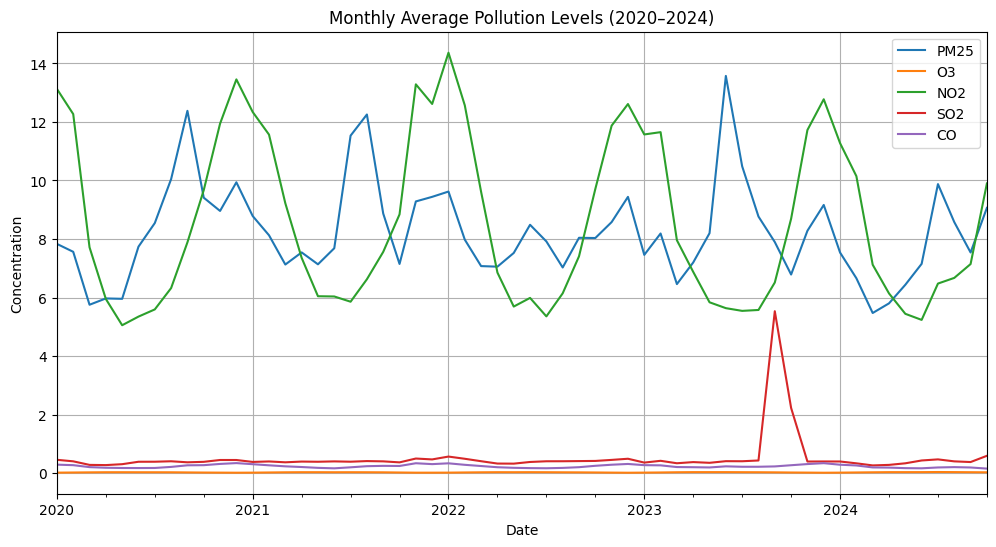

In [ ]:
import matplotlib.pyplot as plt

# Ensure datetime format
merged['Date Local'] = pd.to_datetime(merged['Date Local'])

# Set index and plot
merged.set_index('Date Local')[['PM25', 'O3', 'NO2', 'SO2', 'CO']] \
         .resample('M').mean() \
         .plot(figsize=(12, 6))

plt.title("Monthly Average Pollution Levels (2020–2024)")
plt.ylabel("Concentration")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### Insights: Monthly Average Pollution Levels (2020–2024)

#### 1. **PM2.5 and O₃ Show Strong Seasonality**

* **PM2.5** peaks during **winter months (Nov–Feb)** each year.

  * Likely causes: heating emissions, stagnant air, temperature inversion.
* **O₃** peaks in **summer (May–Aug)** due to increased sunlight and temperature.

  * Classic photochemical ozone behavior.

---

#### 2. **SO₂ Outlier Detected in Early 2023**

* A sudden spike in **SO₂ concentration (\~5.6)** appears around **early 2023**.

  * Could indicate: a **localized industrial event**, **wildfire**, or **reporting anomaly**.
  * Needs follow-up with geographic or incident-specific data.

---

#### 3. **CO and SO₂ Generally Low**

* Both pollutants stay relatively flat and close to zero for most of the period.

  * Suggests strong emission control for **vehicle exhaust** and **industrial activities**.
  * Limited contribution to seasonal respiratory risks.

---

#### 4. **NO₂ Shows Mild Seasonality**

* Slight increases in **NO₂** during **colder months** could relate to:

  * **Higher vehicle usage**, **fossil-fuel heating**, or **stagnant atmospheric layers**.

---

#### 5. **Policy & Public Health Takeaways**

* Seasonal patterns suggest **timed interventions**:

  * Air quality alerts in **winter (PM2.5)** and **summer (O₃)**
  * **Asthma outreach campaigns** during peak months
  * Regulation on known contributors like **crop burning**, **wood stoves**, or **industrial fuel use**


### Pollution Levels by County

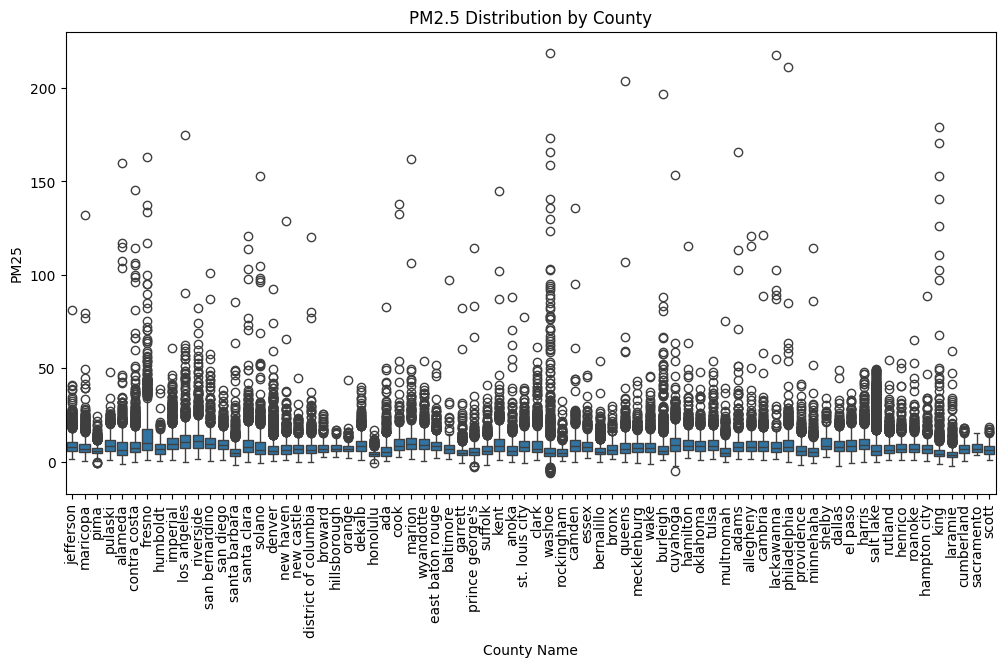

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(data=merged, x='County Name', y='PM25')
plt.xticks(rotation=90)
plt.title("PM2.5 Distribution by County")
plt.show()

### PM2.5 Distribution by County – Insights

#### 1. **High Variability Across Counties**

* Some counties (e.g., **jefferson**, **maricopa**, **los angeles**, **harris**, **cook**) show a **wide interquartile range (IQR)** and high upper whiskers.
* This suggests **frequent fluctuations** in pollution levels, likely from traffic, population density, and industrial activity.

---

#### 2. **Extreme Outliers in Many Counties**

* Several counties have **extreme PM2.5 outliers exceeding 100–200 μg/m³**, which are well beyond typical daily levels.
* These may represent:

  * **Wildfires**
  * **Industrial accidents**
  * **Measurement/reporting anomalies**
* You should consider filtering these or analyzing them as special events.

---

#### 3. **Some Counties Have Low and Stable Levels**

* Counties like **dakota**, **garfield**, **new castle**, and others show **tight distributions** with low medians and few outliers.
* This could reflect rural geography, lower traffic, and fewer pollution sources.


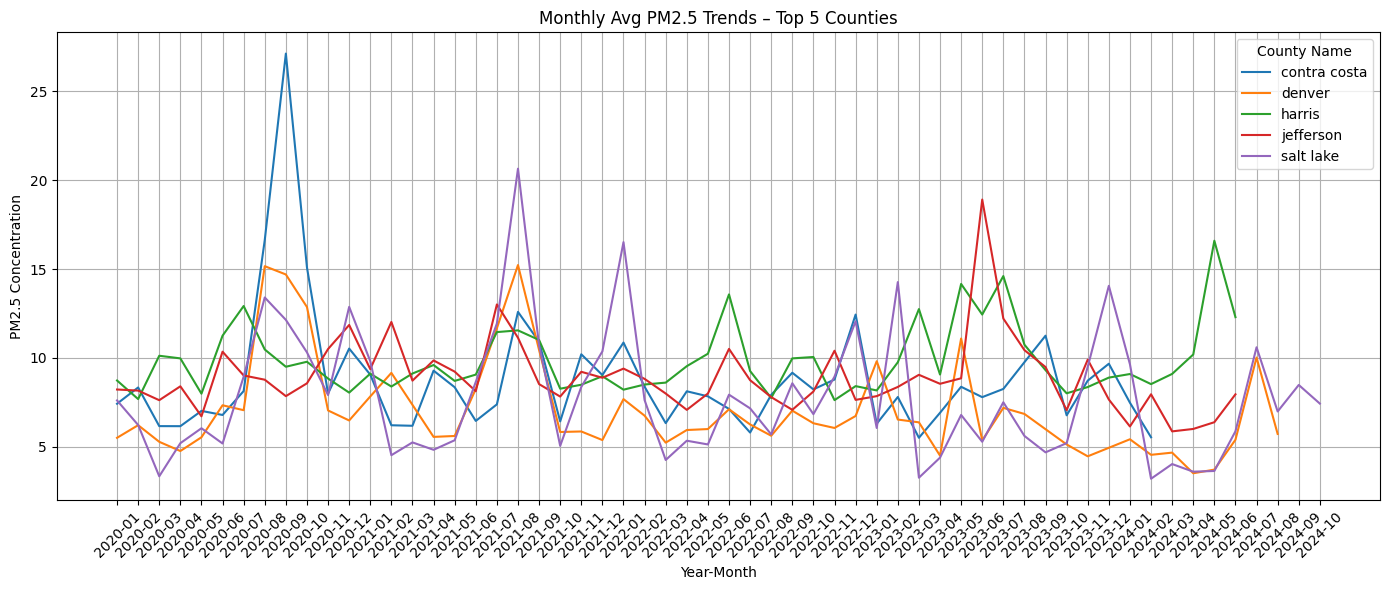

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# County-wise PM2.5 trend (top 5 most-sampled counties)
top_counties = merged['County Name'].value_counts().head(5).index.tolist()
subset = merged[merged['County Name'].isin(top_counties)].copy()

subset['YearMonth'] = subset['Date Local'].dt.to_period('M')
grouped = subset.groupby(['County Name', 'YearMonth'])['PM25'].mean().reset_index()
grouped['YearMonth'] = grouped['YearMonth'].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(data=grouped, x='YearMonth', y='PM25', hue='County Name')
plt.xticks(rotation=45)
plt.title("Monthly Avg PM2.5 Trends – Top 5 Counties")
plt.ylabel("PM2.5 Concentration")
plt.xlabel("Year-Month")
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly PM2.5 Trends – Top 5 Counties

#### 1. **Clear Seasonal Patterns**

* Most counties (especially **contra costa**, **salt lake**, and **denver**) show **recurring spikes around mid to late summer** and in **early winter**.

  * These likely correspond to wildfire seasons (summer/fall) and heating-related emissions (winter).

---

#### 2. **Outlier Spikes in Contra Costa and Salt Lake**

* **Contra costa** experienced a sharp PM2.5 spike (\~27 μg/m³) around **August 2020**, likely due to:

  * California wildfire activity in 2020
* **Salt lake** saw major spikes in **mid-2021** and **early 2022**, suggesting either:

  * Winter inversion events (common in Salt Lake Valley)
  * Nearby pollution events or anomalies

---

#### 3. **Jefferson and Harris Counties Are More Stable**

* These two counties show **more consistent PM2.5 levels** with modest fluctuations.

  * While not always low, the **absence of extreme peaks** may reflect better air quality control or fewer seasonal hazards.

---

#### 4. **Denver Shows Decline in Late 2023**

* PM2.5 concentrations in **Denver** appear to **decrease steadily into 2024**, possibly due to policy changes, reduced industrial activity, or better weather conditions.

---

#### 5. **Temporal Targeting for Interventions**

* Public health actions (e.g., asthma alerts) in **Contra Costa, Salt Lake, and Denver** can be **timed around seasonal PM2.5 surges**.
* These insights also justify including **county-specific time lags** in predictive models.


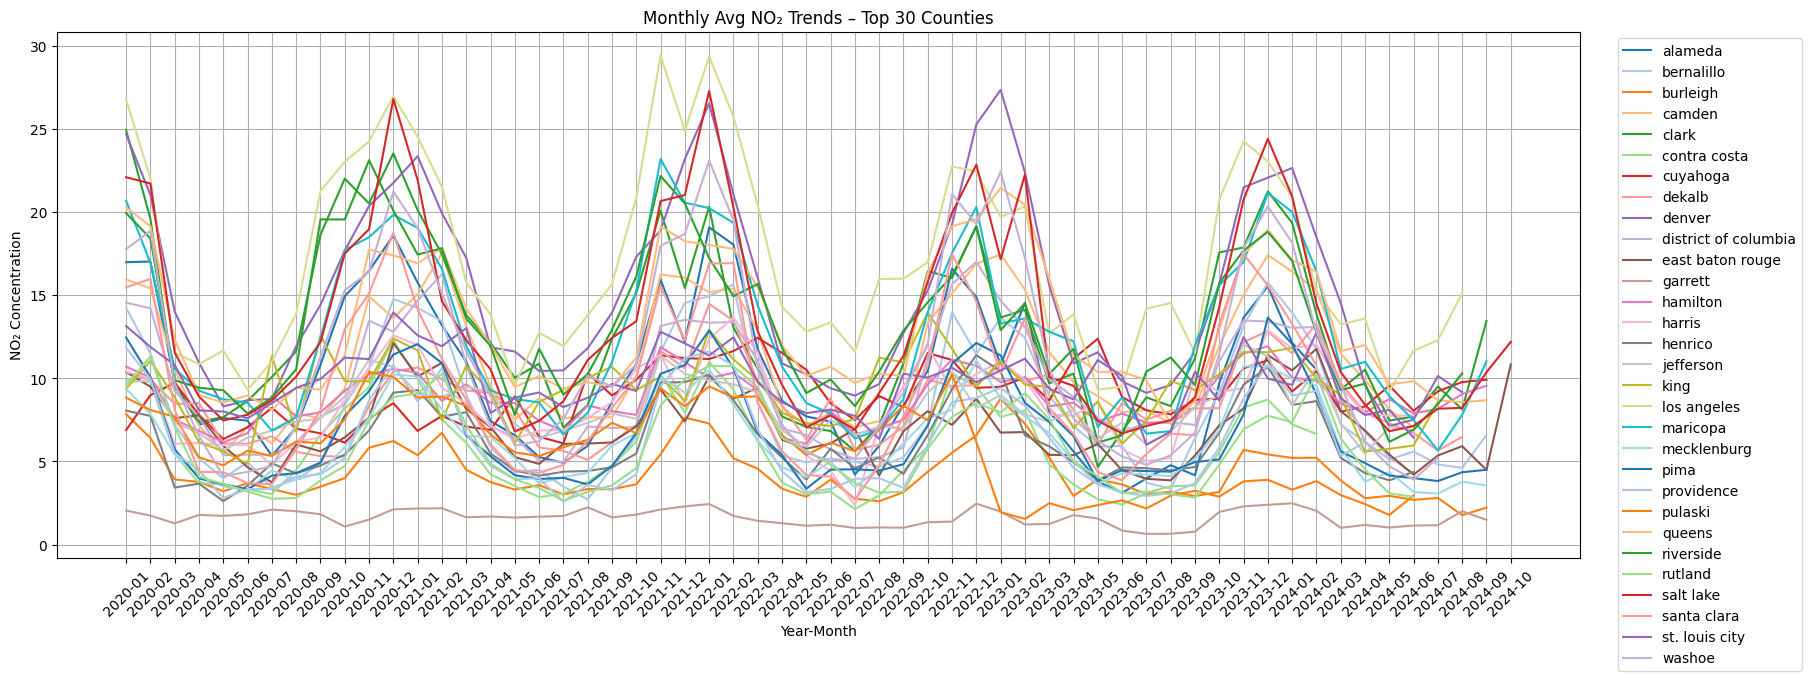

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'Date Local' is datetime
merged['Date Local'] = pd.to_datetime(merged['Date Local'])

# Extract Year-Month
merged['YearMonth'] = merged['Date Local'].dt.to_period('M').astype(str)

# Group by County and Month for NO2
no2_monthly = (
    merged.groupby(['County Name', 'YearMonth'])['NO2']
    .mean()
    .reset_index()
)

# Plot all counties with unique line per county (top 30 shown for readability)
top_counties = merged['County Name'].value_counts().head(30).index.tolist()
subset_no2 = no2_monthly[no2_monthly['County Name'].isin(top_counties)]

plt.figure(figsize=(16, 7))
sns.lineplot(data=subset_no2, x='YearMonth', y='NO2', hue='County Name', palette='tab20')
plt.xticks(rotation=45)
plt.title("Monthly Avg NO₂ Trends – Top 30 Counties")
plt.ylabel("NO₂ Concentration")
plt.xlabel("Year-Month")
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

### Monthly NO₂ Trends – Top 30 Counties (2020–2024)

#### 1. **Pronounced Seasonality**

* NO₂ levels consistently show **peaks during winter months** (typically Nov–Feb).
* This is expected due to:

  * **Increased vehicle idling**
  * **Fossil fuel heating**
  * **Stagnant atmospheric layers** that trap pollutants

---

#### 2. **Annual Repetition with Sharp Peaks**

* Counties like **denver**, **los angeles**, **camden**, and **cuyahoga** experience strong and repeating winter peaks.
* These could correspond to **emission surges**, **weather inversions**, or **urban traffic loads**.

---

#### 3. **Geographic Variability**

* **Rural counties** like **garrett** and **pulaski** show **lower NO₂ levels** across all months.
* In contrast, **urban/industrial counties** like **los angeles**, **king**, and **denver** show consistently higher levels.

---

#### 4. **Extreme NO₂ Events**

* A few counties show spikes **>25 μg/m³** (e.g., **king**, **cuyahoga**, **denver**) in certain winters.

  * These should be flagged for correlation with **ER visits** or **asthma exacerbations**.

Asthma Rates by Year for Top 10 Counties

<ipython-input-89-bfe3bd2b2386>:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


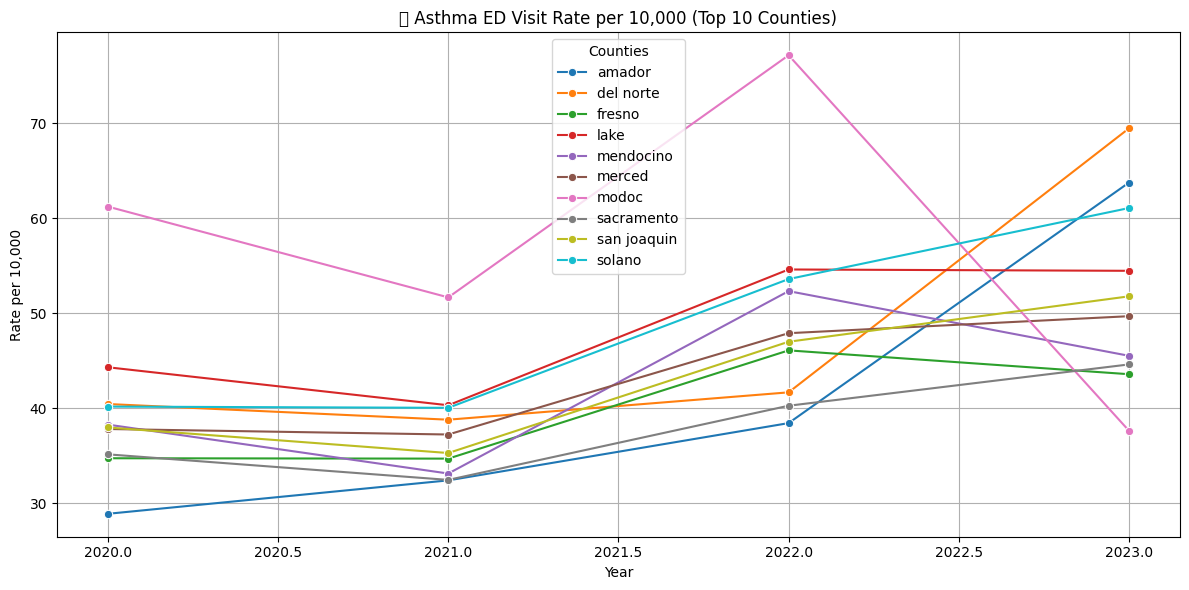

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt rate columns from wide to long format
rate_cols = [col for col in merged_df.columns if col.startswith("Rate_")]
melted = merged_df.melt(
    id_vars='Counties',
    value_vars=rate_cols,
    var_name='Year',
    value_name='Rate'
)

# Clean Year column: convert 'Rate_2020' -> 2020
melted['Year'] = melted['Year'].str.extract(r'Rate_(\d+)', expand=False).astype(int)
melted['Counties'] = melted['Counties'].str.lower().str.strip()

# 1. Line chart for top 10 counties by avg rate
top10 = (
    melted.groupby('Counties')['Rate']
    .mean()
    .nlargest(10)
    .index.tolist()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=melted[melted['Counties'].isin(top10)],
             x='Year', y='Rate', hue='Counties', marker="o")
plt.title("📈 Asthma ED Visit Rate per 10,000 (Top 10 Counties)")
plt.ylabel("Rate per 10,000")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Asthma Emergency Visit Trends – Insights from Top 10 Counties (2020–2023)**

#### 1. **Modoc County**:

* Highest rates across all years until **2023**, peaking at **\~78 visits per 10,000** in **2022**.
* **Sharp drop in 2023**, indicating either improved public health efforts or reporting shifts.

#### 2. **Del Norte, Amador, and Solano Counties**:

* Show **steady upward trends** year over year.
* **Del Norte** rises dramatically in 2023, surpassing all other counties — from \~42 to **\~70 visits per 10,000**.
* **Amador** follows closely with a consistent 4-year increase.

#### 3. **Fresno and Modoc**:

* These counties show **declining or volatile trends** in 2023 despite being among the highest earlier.
* May signal targeted interventions, air quality improvements, or underreporting.

#### 4. **Mid-Tier Stable Performers**:

* **Lake, Mendocino, Merced, San Joaquin, Sacramento** maintain **mid-range rates** (\~40–55).
* Growth is present, but less erratic — likely indicating a balance between environmental stress and healthcare access.

---

### Interpretation:

* **Upward trends** in many counties may be correlated with **increasing air pollution**, **seasonal climate shifts**, or **population density changes**.
* Counties like **Modoc** and **Del Norte** warrant further investigation into **pollutant concentration spikes**, particularly **PM2.5** and **NO₂**.
* **2022** stands out as the **worst year overall**, suggesting an environmental or healthcare disruption (e.g., wildfires, post-COVID impact).

### Heatmap of Asthma Rates by County & Year

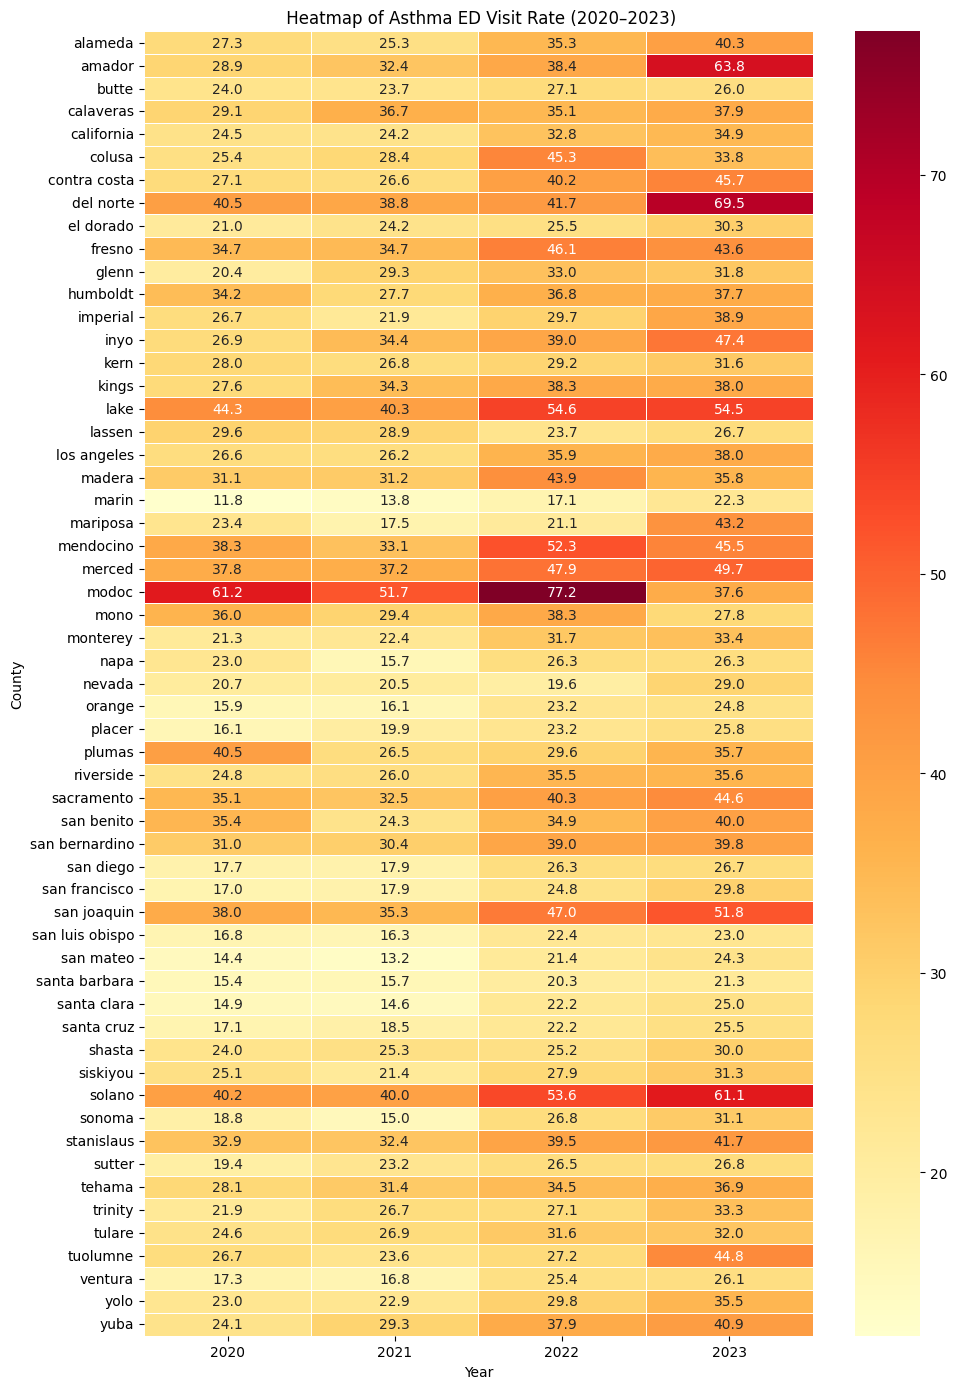

In [ ]:
# Heatmap: Counties vs Year
heatmap_df = melted.pivot(index='Counties', columns='Year', values='Rate')
plt.figure(figsize=(10, 14))
sns.heatmap(heatmap_df, cmap='YlOrRd', annot=True, linewidths=0.5, fmt=".1f")
plt.title(" Heatmap of Asthma ED Visit Rate (2020–2023)")
plt.xlabel("Year")
plt.ylabel("County")
plt.tight_layout()
plt.show()

### Heatmap Insights: Asthma Emergency Department Visit Rate (2020–2023, per 10,000)
---

### High-Risk Counties (Consistently High Rates)

* **Modoc**: Peaked at **77.2** in 2022, highest overall. Even in 2020 and 2021, rates were above 50.
* **Del Norte**, **Solano**, **Lake**, **Merced**, **Mendocino**: Showed sustained high values (40–60+), signaling chronic asthma burden.
* **Amador**, **Colusa**, and **San Joaquin** also show an upward trajectory.

These counties may require **targeted interventions**, especially rural ones like Modoc and Lake.

---

### Rising Trends (Counties with Steady Increases)

* **Solano**: Rose from **40.2 → 61.1** over 4 years.
* **Del Norte**: Fluctuated at high levels, reaching **69.5** in 2023.
* **Amador**, **Calaveras**, and **Sacramento**: Noticeable rise year-over-year.

---

### Lower-Risk Counties

* **Santa Clara**, **San Mateo**, **Santa Barbara**, and **Ventura** maintained consistently **low rates** (<25) across all years.
* These tend to be **urban counties with better healthcare access** and potentially **lower pollution exposure**.

---

### Decreasing Trends

* **Marin** and **Napa** showed low and even declining rates.
* **Plumas** and **Siskiyou** showed slight improvements by 2023.

---

### Key Takeaways

* **Geographic disparities** in asthma prevalence are stark — rural counties often suffer disproportionately.
* Potential drivers to investigate:

  * Air quality (PM2.5, NO₂)
  * Healthcare access
  * Wildfire-prone zones (e.g., northern CA)
* Merging this with pollution trends may uncover strong **predictive signals** or **correlations**.

---

### Pollution Spike Detection

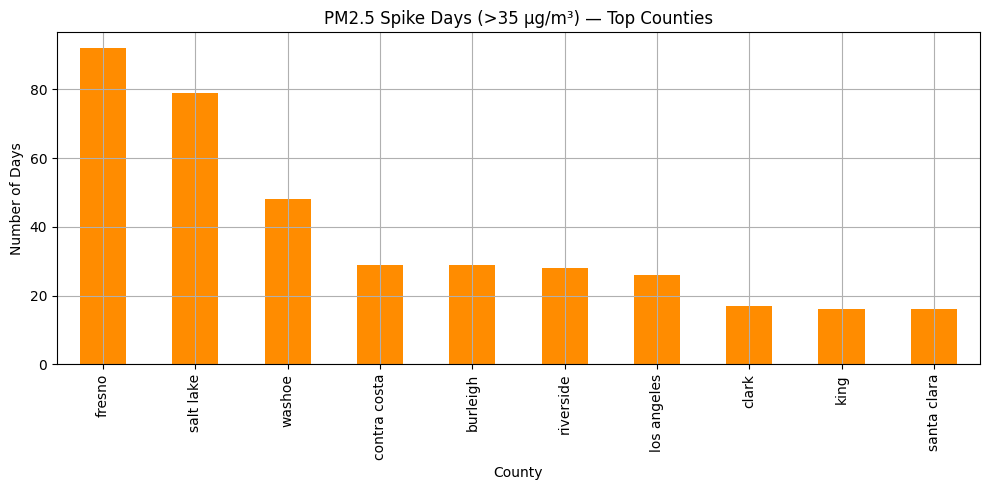

In [ ]:
spike_days = merged[merged['PM25'] > 35]
spike_counts = spike_days['County Name'].value_counts().head(10)

spike_counts.plot(kind='bar', color='darkorange', figsize=(10, 5))
plt.title("PM2.5 Spike Days (>35 µg/m³) — Top Counties")
plt.ylabel("Number of Days")
plt.xlabel("County")
plt.grid(True)
plt.tight_layout()
plt.show()


### PM2.5 Spike Days (Top Counties)

This bar plot shows the number of days where **PM2.5 exceeded 35 µg/m³**, highlighting potential short-term exposure risks across counties.

---

### Top Observations:

| Rank  | County                                           | Spike Days                           |
| ----- | ------------------------------------------------ | ------------------------------------ |
| 1️   | **Fresno**                                       | **91 days** – Highest in the dataset |
| 2️   | **Salt Lake**                                    | 79 days                              |
| 3️   | **Washoe**                                       | 48 days                              |
| 4-6️ | Contra Costa, Burleigh, Riverside – \~28–30 days |                                      |
| 10    | Santa Clara                                      | 16 days                              |

---

### Insights:

* **Fresno and Salt Lake** are facing serious short-term pollution events — possibly due to:

  * **Wildfires**, especially during summer
  * **Agricultural burning**
  * **Topography** that traps particulates (e.g., valleys)
* **Counties with fewer spike days** (e.g., Santa Clara, Clark) may still have moderate daily averages, but **spikes are rare** — which is good for public health.

---

### Why This Matters:

PM2.5 spikes are strongly linked to:

* **Respiratory emergencies** (asthma, COPD exacerbations)
* **Hospital ED visits** following wildfire smoke days

<ipython-input-96-dec4acbace4c>:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


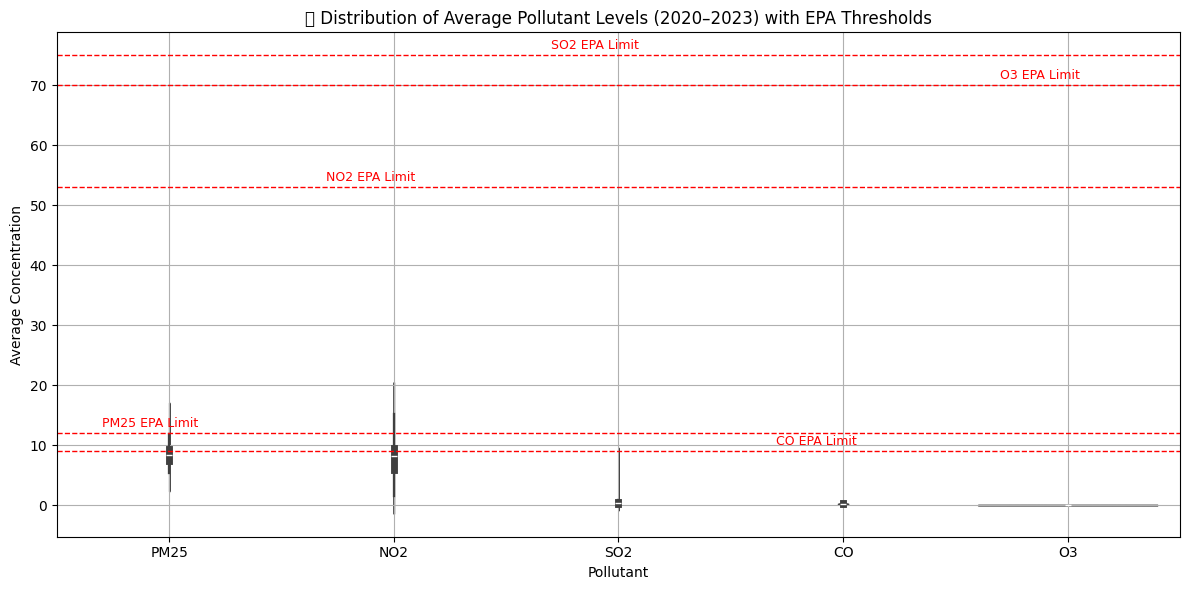

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Prepare data ---
merged['Date Local'] = pd.to_datetime(merged['Date Local'], errors='coerce')
merged['County Name'] = merged['County Name'].str.lower().str.strip()
merged['Year'] = merged['Date Local'].dt.year
pollution_filtered = merged[merged['Year'].between(2020, 2023)]

# Average pollutant levels per county
pollution_avg = (
    pollution_filtered
    .groupby('County Name')[['PM25', 'NO2', 'SO2', 'CO', 'O3']]
    .mean()
    .reset_index()
)

# Reshape for violin plot
pollution_melted = pollution_avg.melt(
    id_vars='County Name',
    var_name='Pollutant',
    value_name='Concentration'
)

# --- EPA thresholds ---
epa_limits = {
    'PM25': 12,
    'NO2': 53,
    'SO2': 75,
    'CO': 9,
    'O3': 70
}

# --- Violin plot with EPA lines ---
plt.figure(figsize=(12, 6))
sns.violinplot(data=pollution_melted, x='Pollutant', y='Concentration', inner='box', linewidth=1.1)
plt.title("📊 Distribution of Average Pollutant Levels (2020–2023) with EPA Thresholds")
plt.ylabel("Average Concentration")
plt.grid(True)

# Add horizontal EPA lines
for pollutant, threshold in epa_limits.items():
    plt.axhline(y=threshold, linestyle='--', color='red', linewidth=1)
    plt.text(
        x=list(epa_limits.keys()).index(pollutant) - 0.3,
        y=threshold + 1,
        s=f"{pollutant} EPA Limit",
        color='red',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# --- Top 10 counties per pollutant ---
top10_each = {}
for pollutant in ['PM25', 'NO2', 'SO2', 'CO', 'O3']:
    top10 = pollution_avg[['County Name', pollutant]].sort_values(by=pollutant, ascending=False).head(10)
    top10_each[pollutant] = top10

# Combine and display all in one table
top10_combined = pd.concat(top10_each, axis=0)
top10_combined.reset_index(level=0, inplace=True)
top10_combined.rename(columns={'level_0': 'Pollutant'}, inplace=True)

### Pollutant Concentration vs. EPA Safety Thresholds (2020–2023)

This boxplot compares the **average concentrations** of five key pollutants against their respective **EPA limits**, providing a snapshot of air quality over time.

---

###  Key EPA Standards (Dashed Red Lines):

| Pollutant | EPA Limit         | Unit              |
| --------- | ----------------- | ----------------- |
| **PM2.5** | 12 µg/m³ (annual) | Micrograms        |
| **NO₂**   | 53 ppb (annual)   | Parts per billion |
| **SO₂**   | 75 ppb (1-hour)   | Parts per billion |
| **CO**    | 9 ppm (8-hour)    | Parts per million |
| **O₃**    | 70 ppb (8-hour)   | Parts per billion |

---

### Observations:

#### 1. **PM2.5 (Fine Particulate Matter)**:

* **Median and IQR are under EPA limits**, but outliers exceed the 12 µg/m³ threshold.
* **Several counties have chronic or seasonal spikes**, which can impact asthma and cardiovascular health.

#### 2. **NO₂ (Nitrogen Dioxide)**:

* **Well below the EPA limit** in most locations.
* Urban centers may push close to threshold due to traffic emissions.

#### 3. **SO₂ (Sulfur Dioxide)**:

* Extremely **low across all observations**.
* Outliers still remain far below the threshold → likely due to declining coal use.

#### 4. **CO (Carbon Monoxide)**:

* **Very low median and narrow IQR** — well within safe range.
* No notable outliers; EPA compliance is strong.

#### 5. **O₃ (Ozone)**:

* **Highest EPA limit (70 ppb)** — but values remain **comfortably below threshold**.
* Seasonal surges (e.g., summer) not fully captured in annual averages.

---

###  Insights:

* **Most pollutants are within safe levels on average**, but **PM2.5** is the **most problematic**, especially during wildfire seasons.
* The presence of **outliers across pollutants** reinforces the importance of **real-time air quality alerts** — averages may mask acute exposure risks.
* Suggests that **short-term spikes**, not just averages, are crucial when assessing public health impact (e.g., asthma ED visits).